### - For this week, I need to generate dummy data to test out this method because the experimental data is not accurate <br>

# Steps:
     - Apply savgol filter, find local minimum and maximums, remove all data prior to the very 1st local max peak.
          - Mins/Maxs are important for calculating initial parameter guesses for the model
     - Cut the dataframe at the first peak, then recalculate minimums and maximums
     - Calculate waveform parameters from the cleaned waveform 
     - Fit the model waveform onto the smoothed, raw data
 

In [264]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy.optimize import curve_fit
from scipy.stats import norm
import seaborn as sns
from scipy import optimize
import math
from scipy import signal

In [265]:
exp = input("Input the number corresponding to the experiment you wish to analyze: ")
file_path = 'Exp'+ str(exp) + '.csv'
data = pd.read_csv(os.path.expanduser("~/Desktop/exp/" + file_path))

Input the number corresponding to the experiment you wish to analyze: 1


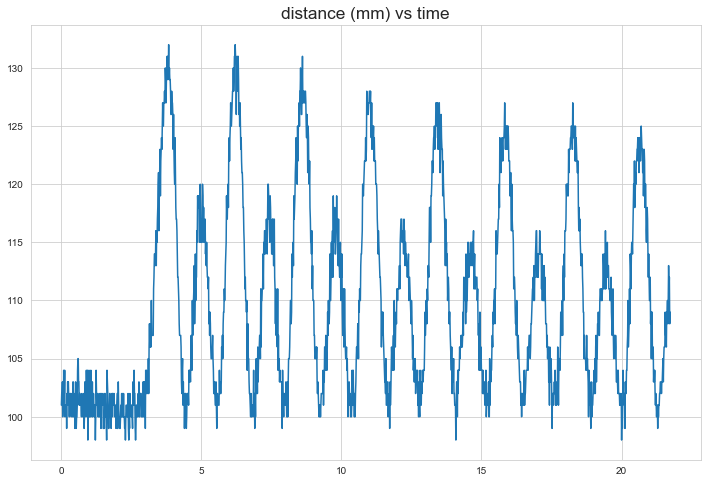

In [355]:
data.columns = ['TOF time','d','DOF time','acc_x','acc_y','acc_z','magn_x','magn_y','magn_z', 'gyr_x','gyr_y','gyr_z']
data.head(5)
plt.figure(figsize=(12,8))
plt.title(label="distance (mm) vs time", fontsize="xx-large")
plt.plot(data['TOF time'], data['d'])

In [267]:
df = data[['TOF time','d']]
df = df.rename({'TOF time': 'time'}, axis=1)

### I will try applying a savgol filter to see if that smooths out the noise enough to locate minimums and maximums

Length of data went from 1627 to 1627
Windows = 55


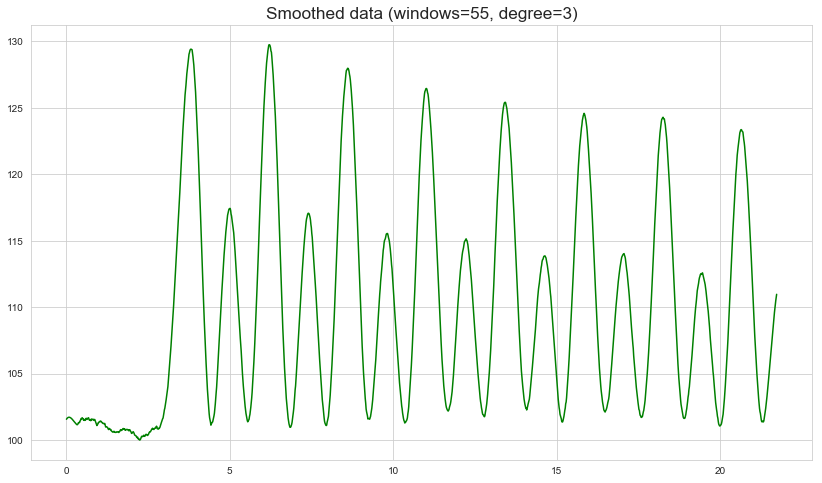

In [356]:
from matplotlib import gridspec


plt.figure(figsize=(14, 8))
windows = 55
savgol = signal.savgol_filter(df['d'], windows, 3) # set to 37, 5 for exp 5
plt.title(label="Smoothed data (windows=55, degree=3)", fontsize="xx-large")
plt.plot(df['time'], savgol,"green",label='smoothing filter applied')
print("Length of data went from", len(df['d']), "to", len(savgol))
print("Windows =", windows)

# Is scipy clever enough to locate the max/mins with 51 windows? Not quite

In [269]:
# Apply the filter and test it out

df['dd'] = signal.savgol_filter(df['d'], windows, 3)
df.head(5)

,time,d,dd
0,0.011916,101.0,101.566559
1,0.023654,102.0,101.610415
2,0.035351,102.0,101.646089
3,0.047049,103.0,101.674021
4,0.058765,100.0,101.694646


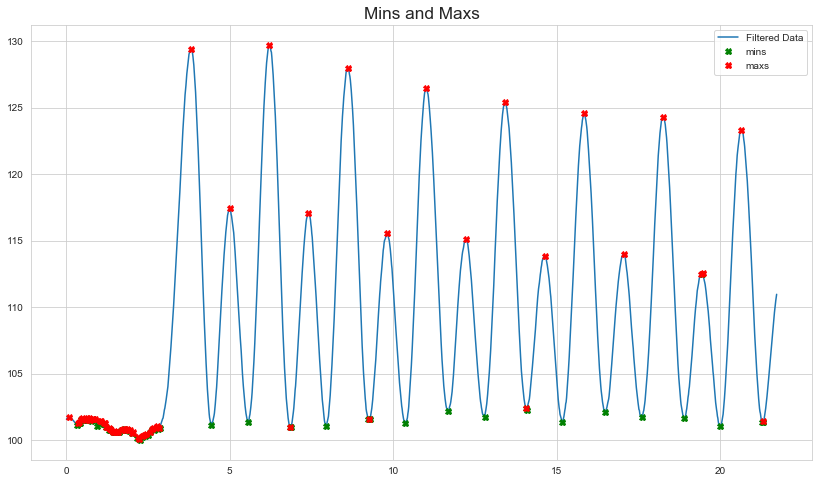

In [353]:
from scipy.signal import argrelextrema
from scipy.signal import find_peaks


dist_arr = df['dd'].to_numpy()
mins = argrelextrema(dist_arr, np.less)[0].tolist()
maxs = argrelextrema(dist_arr, np.greater)[0].tolist()

min_times = []
min_distances = []

max_times = []
max_distances = []

for n in mins:
    min_distances.append(df['dd'].iloc[n]) #retrieves distance at each local minimum's index
    min_times.append(df['time'].iloc[n])

for n in maxs:
    max_distances.append(df['dd'].iloc[n])
    max_times.append(df['time'].iloc[n])




plt.figure(figsize=(14, 8))
plt.plot(df['time'], df['dd'], label='Filtered Data')
plt.plot(min_times, min_distances, "X", color = "green", label="mins")
plt.plot(max_times, max_distances, "X", color = "red", label="maxs")
plt.title(label="Mins and Maxs", fontsize="xx-large")
plt.legend()


### There is some over counting, and it also looks like the Max's and min's sit above the filtered data.
- This is expected/okay. Smoothing our raw data results in slightly less height in the peaks
- One way to remove bad stuff: Remove stuff before the 1st peak

In [271]:
# We want to extract the index of where the 1st true peak occurs. We can safely assume it will be above 110
# Then SLICE df at the point.


cleaned_max = [i for i in max_distances if i >= 110]
index_value = df[df['dd'] == cleaned_max[0]].index.values
index_first_peak = int(index_value)
index_first_peak

290

### Now let's use this index to slice our df

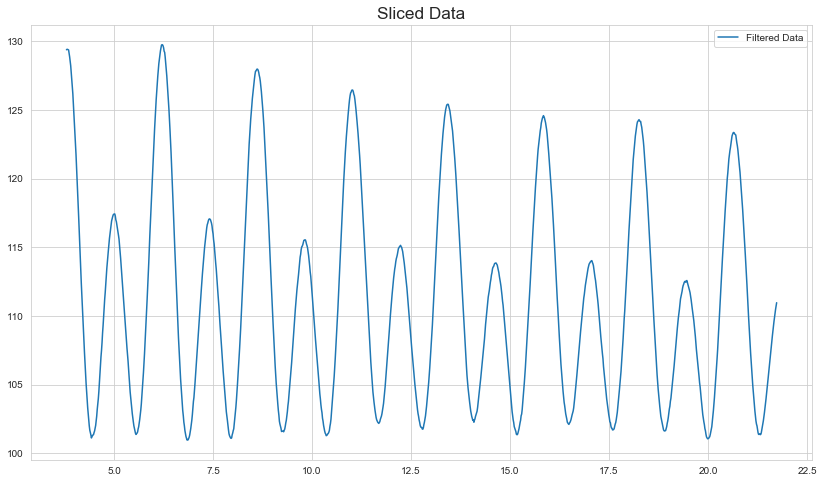

In [352]:
good_df = df.iloc[index_first_peak-1:]

plt.figure(figsize=(14, 8))
plt.plot(good_df['time'], good_df['dd'], label='Filtered Data')
plt.title(label="Sliced Data", fontsize="xx-large")
plt.legend()

# Recalculating max/mins

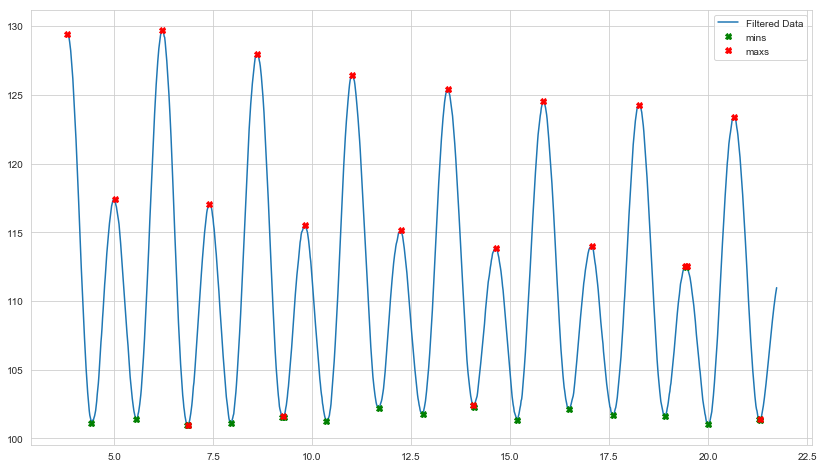

In [273]:
dist_arr = good_df['dd'].to_numpy()
mins = argrelextrema(dist_arr, np.less)[0].tolist()
maxs = argrelextrema(dist_arr, np.greater)[0].tolist()

min_times = []
min_distances = []

max_times = []
max_distances = []

for n in mins:
    min_distances.append(good_df['dd'].iloc[n]) #retrieves distance at each local minimum's index
    min_times.append(good_df['time'].iloc[n])

for n in maxs:
    max_distances.append(good_df['dd'].iloc[n])
    max_times.append(good_df['time'].iloc[n])




plt.figure(figsize=(14, 8))
plt.plot(good_df['time'], good_df['dd'], label='Filtered Data')
plt.plot(min_times, min_distances, "X", color = "green", label="mins")
plt.plot(max_times, max_distances, "X", color = "red", label="maxs")
plt.legend()


### For maximum and minimum amplitudes, I will be doing:
- Amplitude = [Peak height - average(local minimums)] * 1/2
- I am taking the difference between peak and average minimums because I figure that is a good approximation for the center of the pulse

In [274]:
print(max_distances)
print(max_times)
6.212806365999995-3.813278590999971

[129.40496524330607, 117.42022208179938, 129.7399295838315, 101.00805272186325, 117.06377177937092, 127.96777105715447, 101.61762209985372, 115.54095874335023, 126.44526496344669, 115.13675182812045, 125.40965965515014, 102.43027895640338, 113.85279407782694, 124.57539044868622, 114.02719147784502, 124.28356053083843, 112.52651439921351, 112.57768348831705, 123.35305588156508, 101.4249345490728]
[3.813278590999971, 5.0199349650000045, 6.212806365999995, 6.85792306899998, 7.407680674000004, 8.613693693000016, 9.270525769000015, 9.820542911000018, 11.015349065999999, 12.235182974999988, 13.427915309000015, 14.073447084999998, 14.636879901999974, 15.843031247, 17.06498537599998, 18.257731279999973, 19.424336067000013, 19.464560398999996, 20.646195424999974, 21.30249561799997]


2.399527775000024

In [275]:
big_peak = max(max_distances)
print("Highest peak reaches", big_peak, "mm")

small_peak = max(min_distances)
print("Smallest peak reaches", small_peak, "mm")

ground = sum(min_distances)/len(min_distances)
print("Average ground", ground, "mm")

print("\n")

print("Max amplitude:", (big_peak - ground)/2, "mm")
print("Min amplitude:", (small_peak - ground)/2, "mm")
print("Period:", round(6.212806365999995-3.813278590999971,9))


Highest peak reaches 129.7399295838315 mm
Smallest peak reaches 112.45877042521334 mm
Average ground 102.08189943126116 mm


Max amplitude: 13.829015076285167 mm
Min amplitude: 5.188435496976091 mm
Period: 2.399527775


# Testing out cos(x)*exp(-x) fit

- shift left by +(time value of first peak)
- shift up by 1/2 of first peak 
- decay factor -0.03 
- initial amplitude = Max amplitude
- period = 2pi/B -> use B to set period

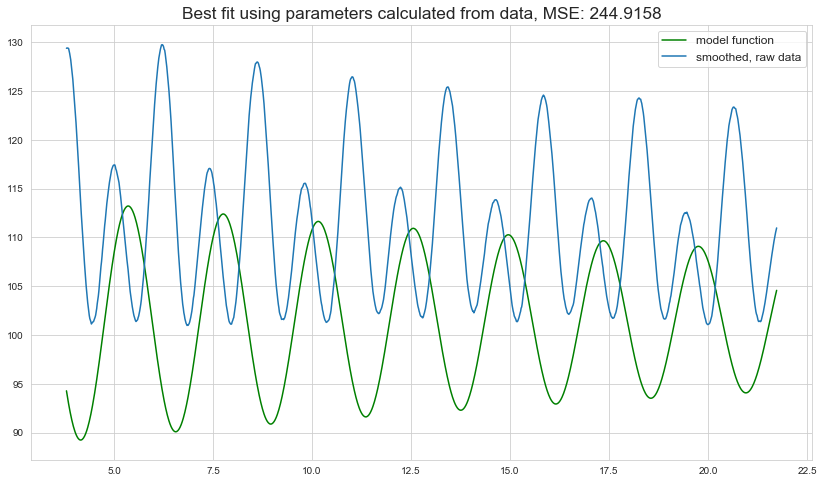

In [357]:
from sklearn.metrics import mean_squared_error




x = good_df['time'].to_numpy()
shift_up = (0.5*(max_distances[0]+min_distances[0])) # Half the first peak
shift_left = max_times[0]  # x-value of where the wave starts
decay = -0.03
amplitude = ((big_peak - ground)/2)
period = 2.399527775
b = (2*np.pi)/period

distances = amplitude*np.sin((b*x)+shift_left)*np.exp(decay*x)+shift_up   
prediction = distances
y = round(mean_squared_error(good_df['dd'], distances),4)

labeler = "Best fit using parameters calculated from data, MSE: " + str(y)

plt.figure(figsize=(14, 8))
plt.plot(x,distances, color="green", label="model function")
plt.plot(good_df['time'], good_df['dd'], label="smoothed, raw data")
plt.title(labeler, fontsize="xx-large")
plt.legend(loc="best", fontsize="large")

# This is pretty close. Once I get my hands on some more accurate data, I think this sort of function should fit nicely

- My max/min finder is still a little sketchy. This can cause issues with all of the analysis if it overcounts

In [277]:
from sklearn.metrics import mean_squared_error

prediction = distances
y = mean_squared_error(good_df['dd'], distances)
print("mean squared error between fit and data:", y)

mean squared error between fit and data: 74.29271384221265


# ~74.3 error after tweaking a bit. I think using scipy to optimize the fit at this point would be good; it minimize the sum of squares 

Best parameters for a,b,c,d:  [-6.33836397e+00  2.61159213e+00 -9.61972702e-03  1.06186342e+00
  1.11178331e+02]
Std. of parameters:  [0.75721741 0.00891854 0.00902613 0.11915365 0.18435927]




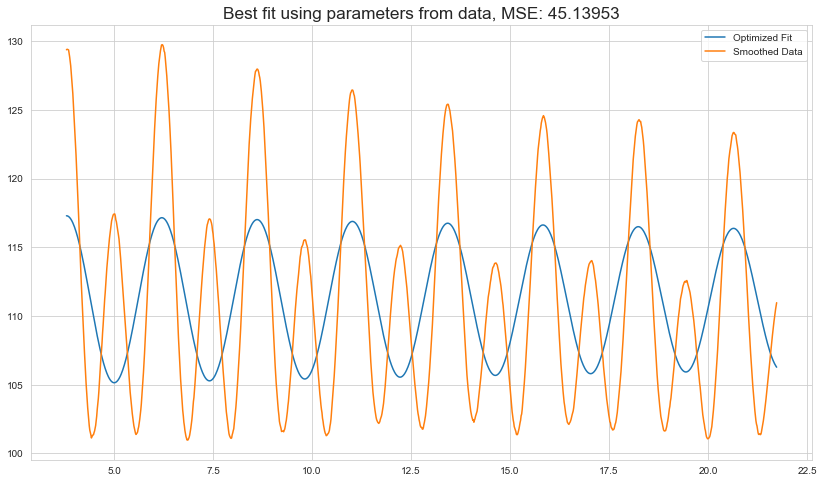

In [358]:
def test_func(x, amp, T, decays, left, up):
    return (amp*np.sin((T*x)+left)*np.exp(decays * x))+up


params, params_covariance = optimize.curve_fit(test_func, good_df['time'], good_df['dd'], 
                                                   p0=[amplitude, b, decay, shift_left, shift_up],maxfev=5000) 

print("Best parameters for a,b,c,d: ", params)
print("Std. of parameters: ", np.sqrt(np.diag(params_covariance)))
print("\n")
plt.figure(figsize=(14, 8))


labeler = "Best fit using parameters from data, MSE: " + str(round(45.13953257548934,5))


plt.plot(good_df['time'], test_func(good_df['time'], params[0], params[1], params[2], params[3], params[4]), label="Optimized Fit")
plt.plot(good_df['time'], good_df['dd'], label='Smoothed Data')
plt.title(labeler, fontsize="xx-large")
plt.legend(loc='best')

# Again, this is very close. I need better data to test these fits.

In [284]:
good_df["scipy_optimal_fit"] = test_func(good_df['time'], params[0], params[1], params[2], params[3], params[4])
y = mean_squared_error(good_df['dd'], good_df['scipy_optimal_fit'])

print("mean squared error between fit and data:", y)

mean squared error between fit and data: 45.13953257548934


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [294]:
good_df = good_df.rename({'d': 'raw_data', 'dd': 'smoothed_data'}, axis=1)
good_df.tail(5)

,time,raw_data,smoothed_data,scipy_optimal_fit
1622,21.678064,113.0,109.916913,106.530515
1623,21.691491,111.0,110.211995,106.456601
1624,21.704858,112.0,110.486170,106.388804
1625,21.718224,108.0,110.737468,106.326862
1626,21.731633,109.0,110.963924,106.270680


# Results
- Discovered a solid method for cleaning data: Savgol filter -> Identify first peak -> Slice DF
- Discovered 2 methods for fitting and calculating error 
     - 1) Extract waveform properties from the cleaned data then model it yourself
     - 2) Let Scipy decide on the optimal parameters for the waveform <br>
### Using either method, we can calculate period and values directly from the resulting fit (since its smooth, less problems)
     
# Moving forward
- Once I have proper data, the fits should look nicer, and MSE's should be significantly reduced.
- Once we have a fit on accurate data, we can compare expected periods (fit) vs experimental periods
- This lets us assert that some periods behave unexpectedtly
     - We can use this to calculate uncertainty in G from period possibly?

# Dummy data w/ noise test

In [317]:
print(len(good_df))

1338


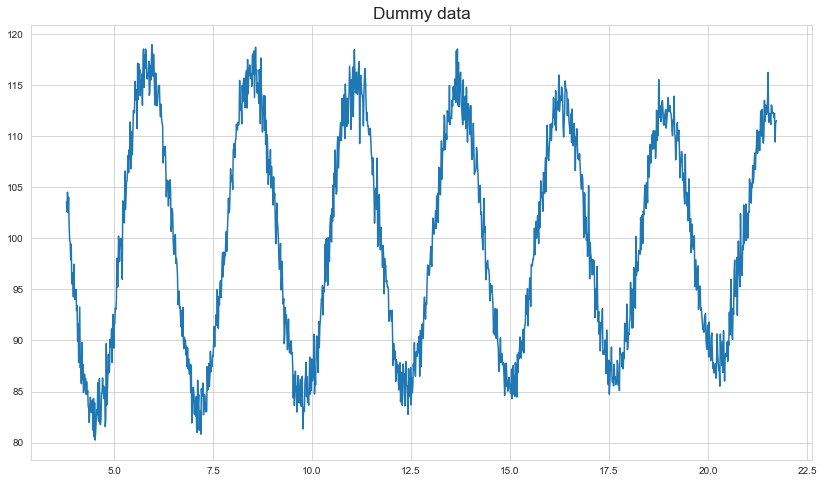

In [359]:
dummy_times = np.linspace(good_df['time'].iloc[0], good_df['time'].iloc[-1], len(good_df))
dummy_distances = ((20*np.sin((2.4*x)+.1)*np.exp(-.024*x)+100))
noisey = dummy_distances.tolist()
noisey = [(i + 1.5*np.random.normal(0,1)) for i in dummy_distances]
#Now add some noise to this dataplt.figure(figsize=(14, 8))
plt.figure(figsize=(14, 8))
plt.title("Dummy data", fontsize="xx-large")
plt.plot(dummy_times, noisey)


Best parameters for a,b,c,d:  [ 1.97106500e+01  2.40006000e+00 -2.29165339e-02  9.62357522e-02
  1.00050523e+02]
Std. of parameters:  [0.19203108 0.00076647 0.00076439 0.00958128 0.04119561]


mean squared error between scipy fit and fake data: 0.007517663688475528


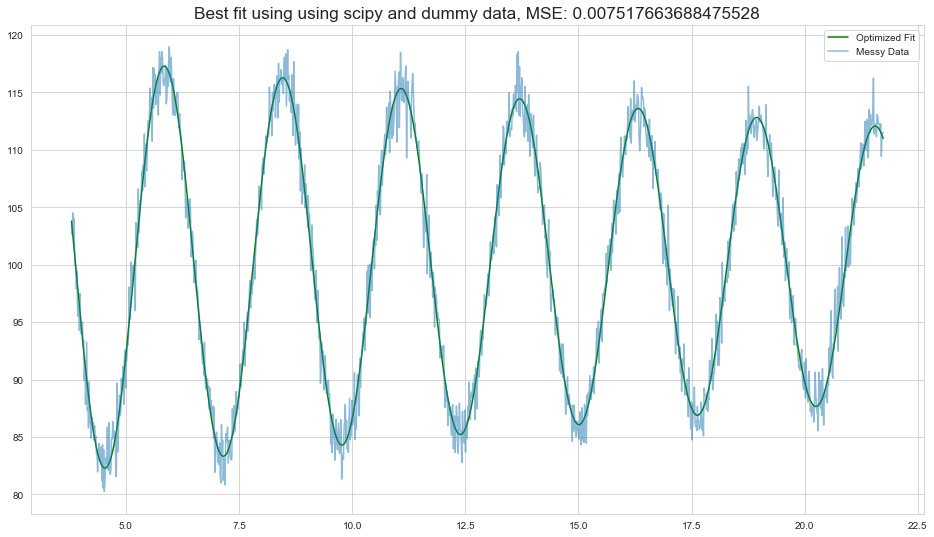

In [361]:
def test_func(x, amp, T, decays, left, up):
    return (amp*np.sin((T*x)+left)*np.exp(decays * x))+up


params, params_covariance = optimize.curve_fit(test_func, dummy_times, noisey, 
                                                   p0=[amplitude, b, decay, shift_left, shift_up],maxfev=5000) 

print("Best parameters for a,b,c,d: ", params)
print("Std. of parameters: ", np.sqrt(np.diag(params_covariance)))
print("\n")
plt.figure(figsize=(16, 9))


y = mean_squared_error(dummy_distances, test_func(dummy_times, params[0], params[1], params[2], params[3], params[4]))
print("mean squared error between scipy fit and fake data:", y)
labeler = "Best fit using using scipy and dummy data, MSE: " + str(y)


plt.plot(dummy_times, test_func(dummy_times, params[0], params[1], params[2], params[3], params[4]), color="green",label="Optimized Fit")
plt.plot(dummy_times, noisey, label='Messy Data', alpha=0.5)
plt.title(label=labeler, fontsize="xx-large")
plt.legend(loc='best')

mean squared error between scipy fit and fake data: 0.02643884294671868
